# 17기 Clustering 정규세션 과제

## Clustering 해보기
### 1. Preprocssing / EDA
지금까지 배운 내용을 토대로 해당 데이터에 대해 자유롭게 전처리와 EDA를 진행해주세요.
### 2. Clustering 
수업 내용 및 실습 자료를 참고하여 클러스터링을 자유롭게 진행해주세요. 한 알고리즘에 대해 파라미터를 바꿔가며 비교를 해도 되고, 여러 알고리즘의 결과를 비교해도 됩니다.
### 3. Evaluation
결과에 대한 평가를 진행하고, 나름의 해석을 달아주세요.

**데이터:** [Mall Customer Segmentation Data| Kaggle](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)

---

## 0. 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [2]:
import pandas as pd
df = pd.read_csv("Mall_Customers.csv", index_col = 0)
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [4]:
#범주형 변수 Gender에 대해 One-Hot Encoding

from sklearn.preprocessing import OneHotEncoder, StandardScaler

encoder = OneHotEncoder().fit(df[['Gender']]) 
endcoded_data = pd.DataFrame(encoder.transform(df[['Gender']]).toarray(), index = df.index,
                             columns = encoder.get_feature_names(['Gender'])) 
data = pd.concat([df, endcoded_data], sort = False, axis = 1).drop(['Gender'], axis = 1)
data

c:\users\ss\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male
CustomerID,,,,,
1,19,15,39,0.0,1.0
2,21,15,81,0.0,1.0
3,20,16,6,1.0,0.0
4,23,16,77,1.0,0.0
5,31,17,40,1.0,0.0
...,...,...,...,...,...
196,35,120,79,1.0,0.0
197,45,126,28,1.0,0.0
198,32,126,74,0.0,1.0


## 변수관계 파악하기


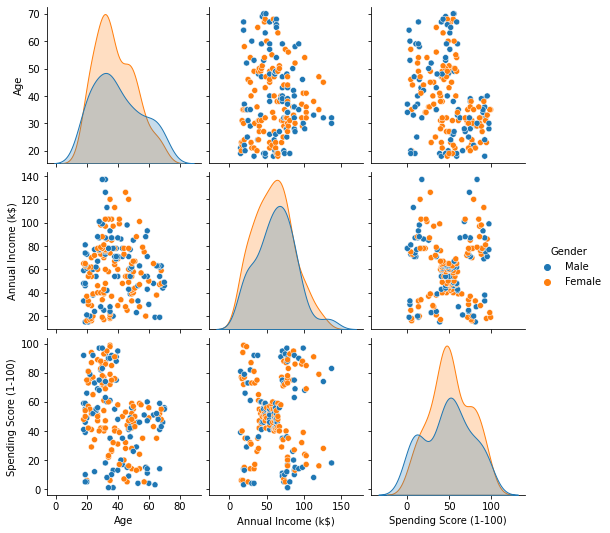

In [5]:
sns.pairplot(df, hue = "Gender")
plt.show()

변수들간의 관계를 파악하기 위해 pairplot을 그렸다.  
`Annual Income`과 `Spending Score` 변수 간에 관계가 잘 군집화될 것으로 보이므로  
본 분석에서는 해당 변수들을 중점으로 클러스터링을 진행하고자 한다.

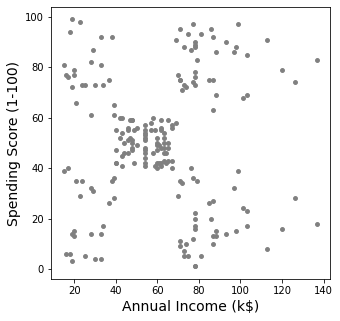

In [6]:
plt.figure(figsize=(5,5))
plt.scatter(data['Annual Income (k$)'],df['Spending Score (1-100)'],s=15,color='grey')
plt.xlabel('Annual Income (k$)',fontsize=14)
plt.ylabel('Spending Score (1-100)',fontsize=14)
plt.show()

두 변수간의 관계를 더 살펴보면, 다음과 같은 다섯 개의 군집으로 나눠질 것이라 기대된다.
- Annual Income과 Spending Score이 모두 작은 군집
- Annual Income은 크고 Spending Score은 작은 군집
- Annual Income과 Spending Score이 모두 중간 범주인 군집
- Annual Income은 작고 Spending Score은 큰 군집
- Annual Income과 Spending Score이 모두 큰 군집

In [7]:
colors=['purple','red','blue','green', 'yellow', 'Cyan']

In [8]:
data1 = data[['Annual Income (k$)', 'Spending Score (1-100)']]

In [9]:
scaler = StandardScaler()
scaler.fit(data1)
data1 = pd.DataFrame(scaler.transform(data1))     # 스케일링한 데이터를 다시 DataFrame으로
data1

,0,1
0,-1.738999,-0.434801
1,-1.738999,1.195704
2,-1.700830,-1.715913
3,-1.700830,1.040418
4,-1.662660,-0.395980
...,...,...
195,2.268791,1.118061
196,2.497807,-0.861839
197,2.497807,0.923953
198,2.917671,-1.250054


분석에 사용할 변수들만 가져오고, 데이터의 단위가 다르기 때문에 Clustering을 위해 데이터 스케일링을 진행했다.

## Hierarchical Clustering

계층적 군집환느 계층적 트리모형을 이용해 개별 개체들을 순차적으로 유사한 군집과 통합하는 군집화 방법으로, 덴드로그램을 통해 시각화가 가능하다. 덴드로그램을 통해 개체들이 결합되는 순서를 파악할 수 있으며, 처음에 군집의 개수를 정하지 않아도 덴드로그램 생성 후 적절 수준에서 자르면 군집화 결과가 생성된다.

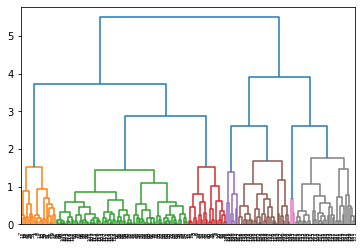

In [10]:
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_matrix = linkage(data1, method='complete', metric='euclidean')
_ = dendrogram(linkage_matrix, color_threshold = 2)

약 4~6개의 군집으로 적절히 나누어짐을 볼 수 있다.

In [11]:
#Single Linkage
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='single')
model.fit(data1)

AgglomerativeClustering(linkage='single', n_clusters=5)

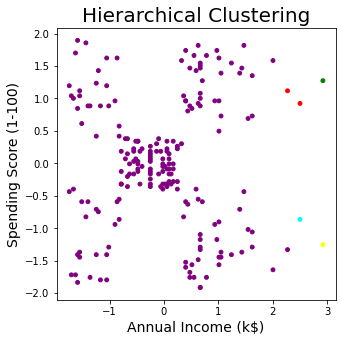

In [12]:
df['HR_labels']=model.labels_

plt.figure(figsize=(5,5))
plt.scatter(data1[0],data1[1],c=df['HR_labels'],cmap=matplotlib.colors.ListedColormap(colors),s=15)
plt.title('Hierarchical Clustering',fontsize=20)
plt.xlabel('Annual Income (k$)',fontsize=14)
plt.ylabel('Spending Score (1-100)',fontsize=14)
plt.show()

Single Linkage는 군집화가 잘 되지 않는다.

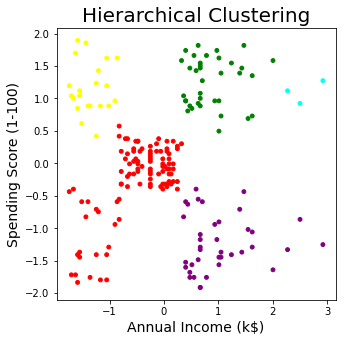

In [13]:
#Average Linkage
model = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='average')
model.fit(data1)

df['HR_labels']=model.labels_
plt.figure(figsize=(5,5))
plt.scatter(data1[0],data1[1],c=df['HR_labels'],cmap=matplotlib.colors.ListedColormap(colors),s=15)
plt.title('Hierarchical Clustering',fontsize=20)
plt.xlabel('Annual Income (k$)',fontsize=14)
plt.ylabel('Spending Score (1-100)',fontsize=14)
plt.show()

군집화 결과가 나쁘지 않지만, 두 변수의 값이 모두 낮은 부분이 중간 부분과 다른 군집으로 분류되길 원했는데 결과가 다소 아쉽다.

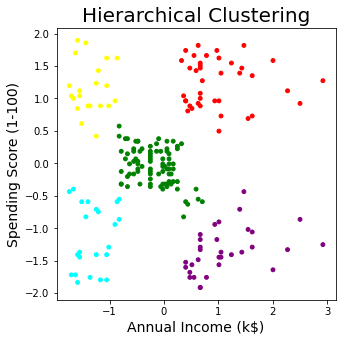

In [14]:
#Ward Linkage
model = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
model.fit(data1)

df['HR_labels']=model.labels_
plt.figure(figsize=(5,5))
plt.scatter(data1[0],data1[1],c=df['HR_labels'],cmap=matplotlib.colors.ListedColormap(colors),s=15)
plt.title('Hierarchical Clustering',fontsize=20)
plt.xlabel('Annual Income (k$)',fontsize=14)
plt.ylabel('Spending Score (1-100)',fontsize=14)
plt.show()

Ward Linkage를 사용하니 예상한 바와 같이 clustering이 잘 되었다.

## K-Means

K-Means Clustering은 대표적인 분리형 군집화 알고리즘으로,  
각 군집은 하나의 중심을 가지며 각 개체는 가장 가까운 중심을 가진 군집에 할당된다.  
계층적 군집화와 달리 사전에 군집수 K가 지정되어야 한다.

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

for n_cluster in range(2, 11):
        kmeans = KMeans(n_clusters = n_cluster)
        kmeans.fit(data1)
        cluster = kmeans.predict(data1)
        score = silhouette_score(data1, cluster)

        print("군집 수 : {}, 실루엣 점수 : {:.3f}".format(n_cluster, score))

군집 수 : 2, 실루엣 점수 : 0.321
군집 수 : 3, 실루엣 점수 : 0.467
군집 수 : 4, 실루엣 점수 : 0.494
군집 수 : 5, 실루엣 점수 : 0.555
군집 수 : 6, 실루엣 점수 : 0.540
군집 수 : 7, 실루엣 점수 : 0.526
군집 수 : 8, 실루엣 점수 : 0.456
군집 수 : 9, 실루엣 점수 : 0.457
군집 수 : 10, 실루엣 점수 : 0.455


실루엣 계수 비교시, 군집의 개수가 5개일 때 실루엣 점수가 가장 높게 나타나므로,  
k-means clustering시 n=5로 지정한다.

In [16]:
k_means=KMeans(n_clusters=5,random_state=42)
k_means.fit(data1)

KMeans(n_clusters=5, random_state=42)

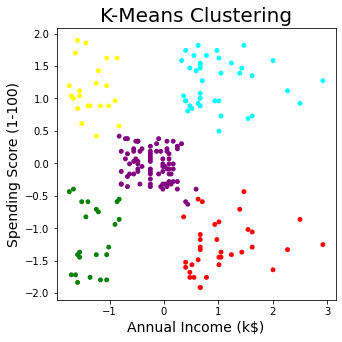

In [17]:
df['KMeans_labels']=k_means.labels_

plt.figure(figsize=(5,5))
plt.scatter(data1[0],data1[1],c=df['KMeans_labels'],cmap=matplotlib.colors.ListedColormap(colors),s=15)
plt.title('K-Means Clustering',fontsize=20)
plt.xlabel('Annual Income (k$)',fontsize=14)
plt.ylabel('Spending Score (1-100)',fontsize=14)
plt.show()

예상한 바와 같이 clustering이 잘 되었다.

## DBSCAN

공간상에 높은 밀도를 가지고 모여있는 관측치들을 하나의 그룹으로 간주하고,  
낮은 밀도를 가지고 있는 관측치는 잡음으로 분류하는 밀도기반 군집화 알고리즘이다.  
하이퍼파라미터로 eps와 min_samples를 갖는데, 한 데이터포인트에서 eps 거리 안에 데이터가 min_samples개수만큼 들어있으면  
데이터포인트를 핵심 샘플로 분류하고 eps보다 가까운 핵심 샘플은 동일한 군집으로 합쳐진다.

In [18]:
from sklearn.cluster import DBSCAN
dbscan=DBSCAN() # eps = 0.5 / min_samples = 5
dbscan.fit(data1[[0,1]])

DBSCAN()

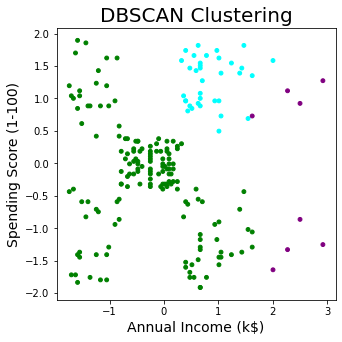

In [19]:
df['DBSCAN_labels']=dbscan.labels_ 

plt.figure(figsize=(5,5))
plt.scatter(data1[0],data1[1],c=df['DBSCAN_labels'],cmap=matplotlib.colors.ListedColormap(colors),s=15)
plt.title('DBSCAN Clustering',fontsize=20)
plt.xlabel('Annual Income (k$)',fontsize=14)
plt.ylabel('Spending Score (1-100)',fontsize=14)
plt.show()

군집화가 잘 이루어지지 않아 하이퍼파라미터 튜닝이 필요하다.  
일반적으로 DBSCAN에서 eps를 결정할 때는 설정한 min_samples개에 대한 knn plot을 그려, knee 포인트를 최적 eps로 설정한다고 한다.

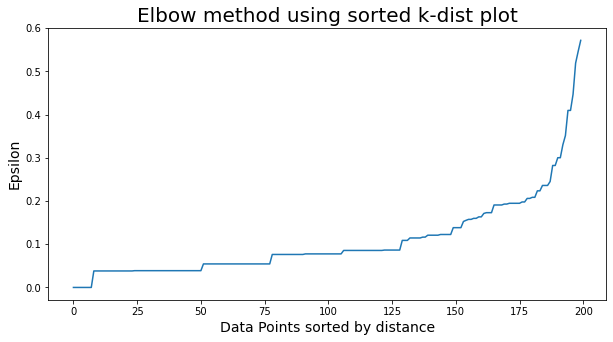

In [20]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=4)    #n 개수를 4로 설정했다.
neighbors = nn.fit(data1[[0,1]])
distances, indices = neighbors.kneighbors(data1[[0,1]])

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,5))
plt.plot(distances)
plt.title('Elbow method using sorted k-dist plot',fontsize=20) # K-distance Graph
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

eps이 약 0.2일 때 knee point를 가지므로 DBSCAN을 다시 적합해보자.

In [21]:
from sklearn.cluster import DBSCAN
dbscan_opt=DBSCAN(eps=0.2,min_samples=4)
dbscan_opt.fit(data1[[0,1]])

DBSCAN(eps=0.2, min_samples=4)

In [22]:
df['DBSCAN_opt_labels']=dbscan_opt.labels_
df['DBSCAN_opt_labels'].value_counts()

 1    79
-1    73
 2    21
 3    14
 0     7
 4     6
Name: DBSCAN_opt_labels, dtype: int64

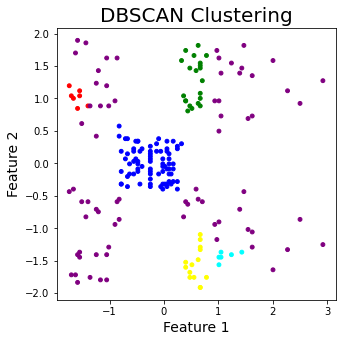

In [23]:
plt.figure(figsize=(5,5))
plt.scatter(data1[0],data1[1],c=df['DBSCAN_opt_labels'],cmap=matplotlib.colors.ListedColormap(colors),s=15)
plt.title('DBSCAN Clustering',fontsize=20)
plt.xlabel('Feature 1',fontsize=14)
plt.ylabel('Feature 2',fontsize=14)
plt.show()

클러스터링 결과가 불안정하다.  
DBSCAN은 밀도 기반 군집화 기법이기 때문에 데이터 간의 분산 차이가 크면 적용이 어려운데,  
해당 데이터셋이 그에 해당하기 때문에 DBSCAN으로 인한 군집화 결과는 좋지 않게 도출된다.